In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import random
import shutil


dataset_path = 'content/drive/MyDrive/data'


train_path = 'content/drive/MyDrive/train'
test_path = 'content/drive/MyDrive/test'


os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)


for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)


    train_class_folder = os.path.join(train_path, class_folder)
    test_class_folder = os.path.join(test_path, class_folder)
    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)


    files = os.listdir(class_path)
    num_files = len(files)


    random.shuffle(files)


    split_index = int(0.8 * num_files)


    train_files = files[:split_index]
    test_files = files[split_index:]


    for file in train_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(train_class_folder, file)
        shutil.copy(src, dst)


    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(test_class_folder, file)
        shutil.copy(src, dst)

print("Dataset split into train and test sets successfully.")


FileNotFoundError: [Errno 2] No such file or directory: 'content/drive/MyDrive/data'

In [ ]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = '/content/drive/MyDrive/train'
test_path = '/content/drive/MyDrive/test'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_gen = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

test_gen = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)


Found 1483 images belonging to 30 classes.
Found 400 images belonging to 30 classes.
Found 400 images belonging to 30 classes.


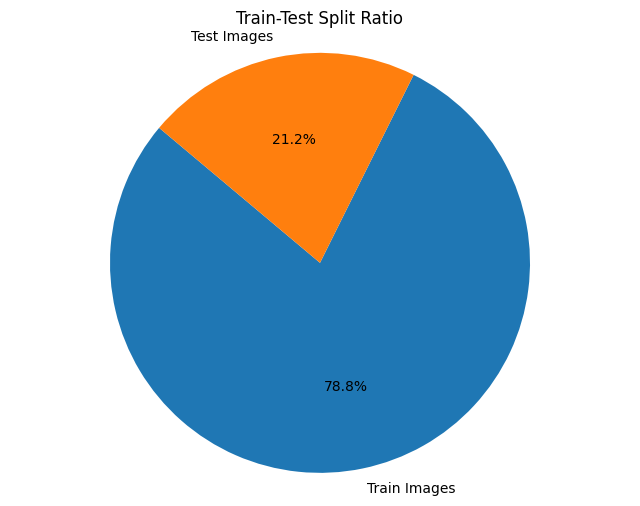

In [ ]:
import os
import matplotlib.pyplot as plt


train_classes = os.listdir(train_path)
test_classes = os.listdir(test_path)

train_class_counts = [len(os.listdir(os.path.join(train_path, class_name))) for class_name in train_classes]
test_class_counts = [len(os.listdir(os.path.join(test_path, class_name))) for class_name in test_classes]


total_train_images = sum(train_class_counts)
total_test_images = sum(test_class_counts)
train_test_ratios = [total_train_images, total_test_images]


plt.figure(figsize=(8, 6))
labels = ['Train Images', 'Test Images']
plt.pie(train_test_ratios, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Train-Test Split Ratio')
plt.axis('equal')
plt.show()




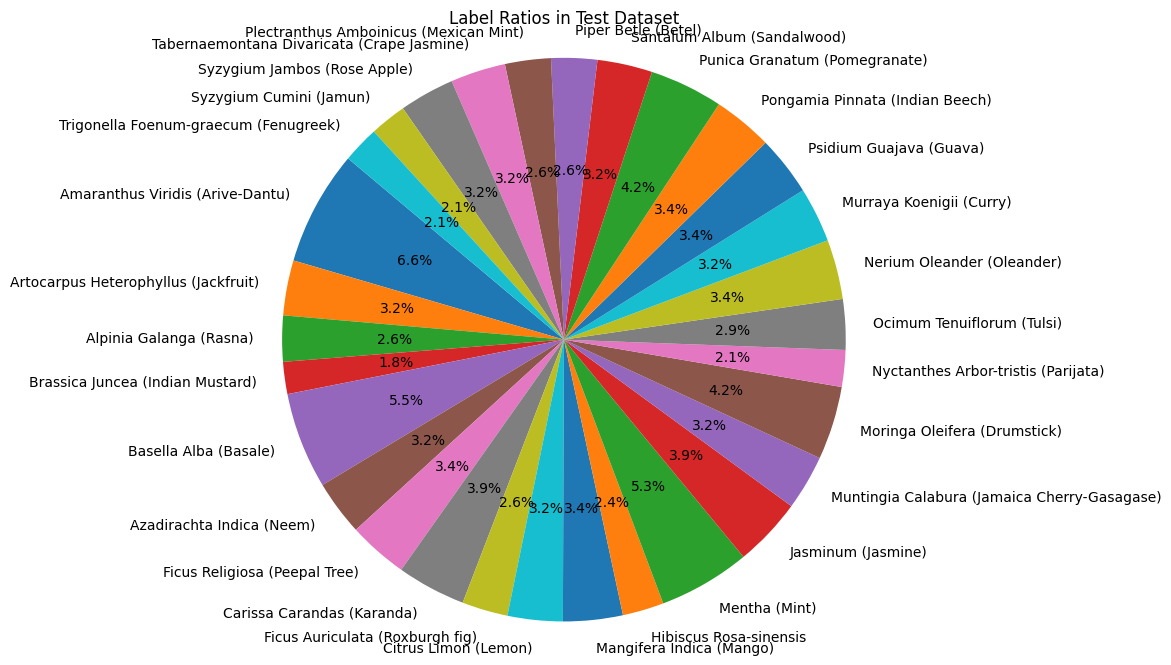

In [ ]:
import os
import matplotlib.pyplot as plt


test_classes = os.listdir(test_path)
test_class_counts = [len(os.listdir(os.path.join(test_path, class_name))) for class_name in test_classes]


plt.figure(figsize=(8, 8))
plt.pie(test_class_counts, labels=test_classes, autopct='%1.1f%%', startangle=140)
plt.title('Label Ratios in Test Dataset')
plt.axis('equal')
plt.show()


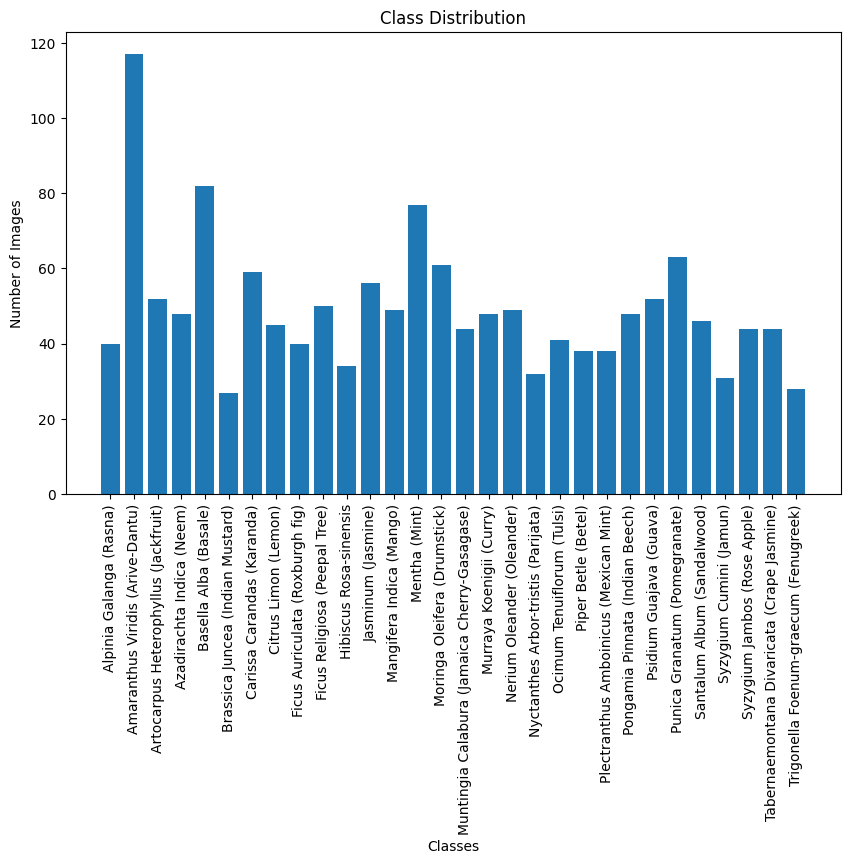

In [ ]:
class_labels = sorted(os.listdir(train_path))


class_counts = []
for label in class_labels:
    class_folder = os.path.join(train_path, label)
    num_images = len(os.listdir(class_folder))
    class_counts.append(num_images)


plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()


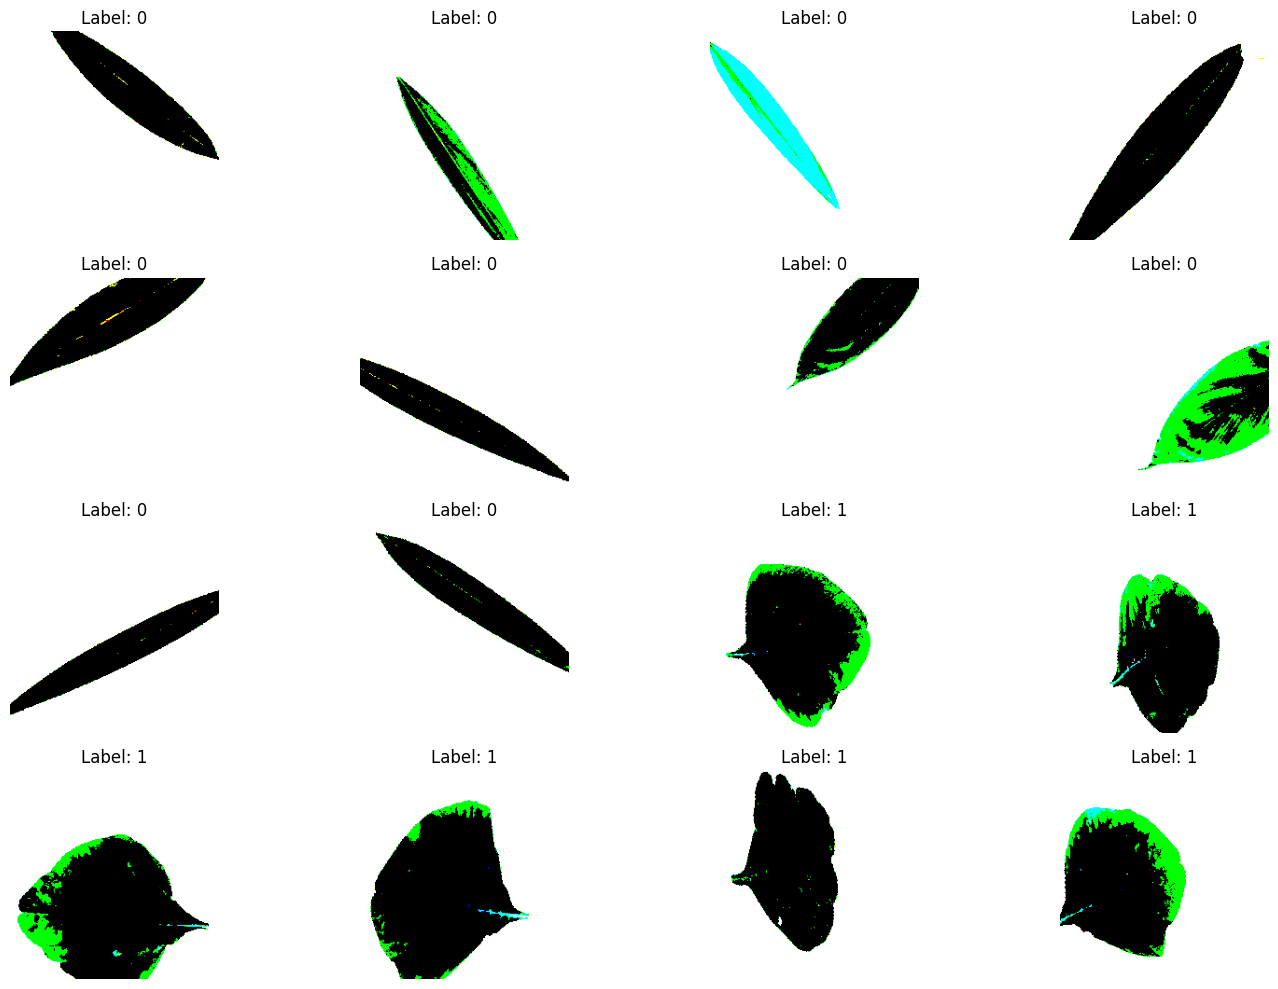

In [ ]:

images, labels = next(valid_gen)


plt.figure(figsize=(15, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f'Label: {np.argmax(labels[i])}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
input_shape = (224, 224, 3)


pretrained_model = ResNet50(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)


pretrained_model.trainable = False


inputs = pretrained_model.input
x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.5)(x)
outputs = Dense(31, activation='softmax')(x)


model = Model(inputs=pretrained_model.input, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
import matplotlib.pyplot as plt


history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=7,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)]
)


test_results = model.evaluate(test_gen)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/7


InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-27-039e35ca6ea4>", line 4, in <cell line: 4>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5579, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,31] labels_size=[32,30]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_27363]

In [ ]:
misclassified_images = []
true_labels = []

for image_batch, label_batch in test_gen:
    predictions = model.predict(image_batch)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels.extend(label_batch)

    misclassified_mask = predicted_labels != np.argmax(label_batch, axis=1)
    misclassified_images.extend(np.array(image_batch)[misclassified_mask])

    if len(misclassified_images) >= 10:
        break


for img in misclassified_images:
    plt.imshow(img)
    plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet50 import preprocess_input
import urllib.parse


image_path = input("Enter the path of the image: ")


img = cv2.imread(image_path)
img = cv2.resize(img, (224, 224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img = keras_image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)


prediction = model.predict(img)
predicted_class_index = np.argmax(prediction)


class_labels = sorted(os.listdir(train_path))
predicted_class_label = class_labels[predicted_class_index]

print(f"The predicted class is: {predicted_class_label}")


plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title(f"Predicted class: {predicted_class_label}")
plt.axis('off')
plt.show()


search_query = urllib.parse.quote_plus(predicted_class_label)
google_link = f"https://www.google.com/search?q={search_query}"

print(f"Google search link for '{predicted_class_label}': {google_link}")
